<p style="color: #000000; font-size: 32px; font-weight: bold; text-align: center; margin-top: 20px;"> 
    California Housing Prices
</p>
<p style="color: #000000; font-size: 24px; text-align: center; margin-bottom: 20px;"> 
    Predicción del valor medio de las viviendas
</p>

# 1. Diccionario

**Californa Housing Prices DataFrame**:

**`longitude`**: Medida de qué tan al oeste se encuentra una casa; un valor más alto indica una ubicación más al oeste.    
**`latitude`**: Medida de qué tan al norte se encuentra una casa; un valor más alto indica una ubicación más al norte.    
**`housing_median_age`**: Edad media de las casas dentro de una manzana; un número más bajo representa una construcción más nueva.    
**`total_rooms`**: Número total de habitaciones dentro de una manzana.   
**`total_bedrooms`**: Número total de dormitorios dentro de una manzana.   
**`population`**: Número total de personas que viven dentro de una manzana.   
**`households`**: Número total de hogares, definidos como grupos de personas que viven en una misma vivienda, dentro de una manzana.   
**`median_income`**: Ingreso medio de los hogares dentro de una manzana (medido en decenas de miles de dólares estadounidenses).  
**`median_house_value`**: Valor medio de las viviendas dentro de una manzana (medido en dólares estadounidenses).   
**`ocean_proximity`**: Ubicación de la casa en relación con el océano o el mar.   

# 2. Librerias

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Visualization configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 3. Load the Data

In [36]:
housing_df = pd.read_csv('housing.csv')
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [37]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


**Primera revisión del DataFrame**:

1. **Forma**: El DataFrame tiene **20,640 filas** y **10 columnas**.
2. **Columna `ocean_proximity`**: Es necesario reasignar los valores.
3. **Valores faltantes**: La columna `total_bedrooms` tiene **207 valores faltantes**.
4. **Nombres de columnas y tipos de datos**: Parecen correctos.
5. **Duplicados**: Se realizará una verificación de filas duplicadas.

#  4. Preprocesamiento de Datos

In [10]:
# Copy dataset for cleaning
housing_clean = housing_df.copy()

# Impute missing values in total_bedrooms with median
bedroom_median = housing_clean['total_bedrooms'].median()
housing_clean['total_bedrooms'].fillna(bedroom_median, inplace=True)
print(f"Missing values imputed with median: {bedroom_median:.1f}")

# Verify changes
print(f"Remaining missing values: {housing_clean.isnull().sum().sum()}")
print(f"Duplicates: {housing_clean.duplicated().sum()}")

Missing values imputed with median: 435.0
Remaining missing values: 0
Duplicates: 0


In [12]:
# Create new features
housing_clean['rooms_per_household'] = housing_clean['total_rooms'] / housing_clean['households']
housing_clean['bedrooms_per_room'] = housing_clean['total_bedrooms'] / housing_clean['total_rooms']
housing_clean['population_per_household'] = housing_clean['population'] / housing_clean['households']
housing_clean['income_per_room'] = housing_clean['median_income'] / housing_clean['total_rooms']

# Ocean proximity analysis
print(housing_clean['ocean_proximity'].value_counts())

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64


# 5. Análisis Exploratorio Inicial


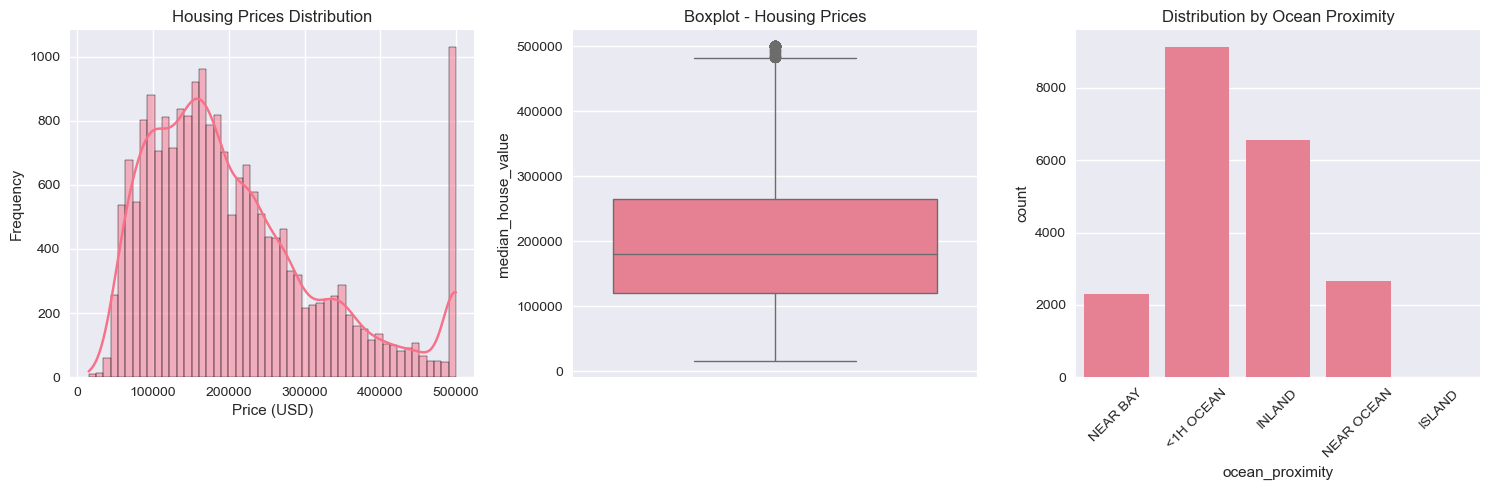

In [14]:
# Target variable distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(housing_clean['median_house_value'], bins=50, kde=True)
plt.title('Housing Prices Distribution')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.boxplot(y=housing_clean['median_house_value'])
plt.title('Boxplot - Housing Prices')

plt.subplot(1, 3, 3)
sns.countplot(data=housing_clean, x='ocean_proximity')
plt.title('Distribution by Ocean Proximity')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**Distribución de precios (izquierda):**  
La mayoría de las viviendas tienen precios entre **100,000 y 250,000 USD**, con una fuerte concentración alrededor de los **150,000 USD**. Se observa un **sesgo a la derecha**, es decir, existen algunas viviendas mucho más caras (*outliers*).

**Diagrama de caja (centro):**  
La **mediana** del valor de las viviendas está cerca de **180,000 USD**, con algunos valores atípicos por encima de los **500,000 USD**. Esto confirma la presencia de **precios extremos** detectada en el histograma.

**Distribución por proximidad al océano (derecha):**  
La mayoría de las propiedades están ubicadas **a menos de una hora del océano** (`<1H OCEAN`) o en **zonas interiores** (`INLAND`), mientras que hay pocas cerca de la **bahía** (`NEAR BAY`) o en **islas** (`ISLAND`).

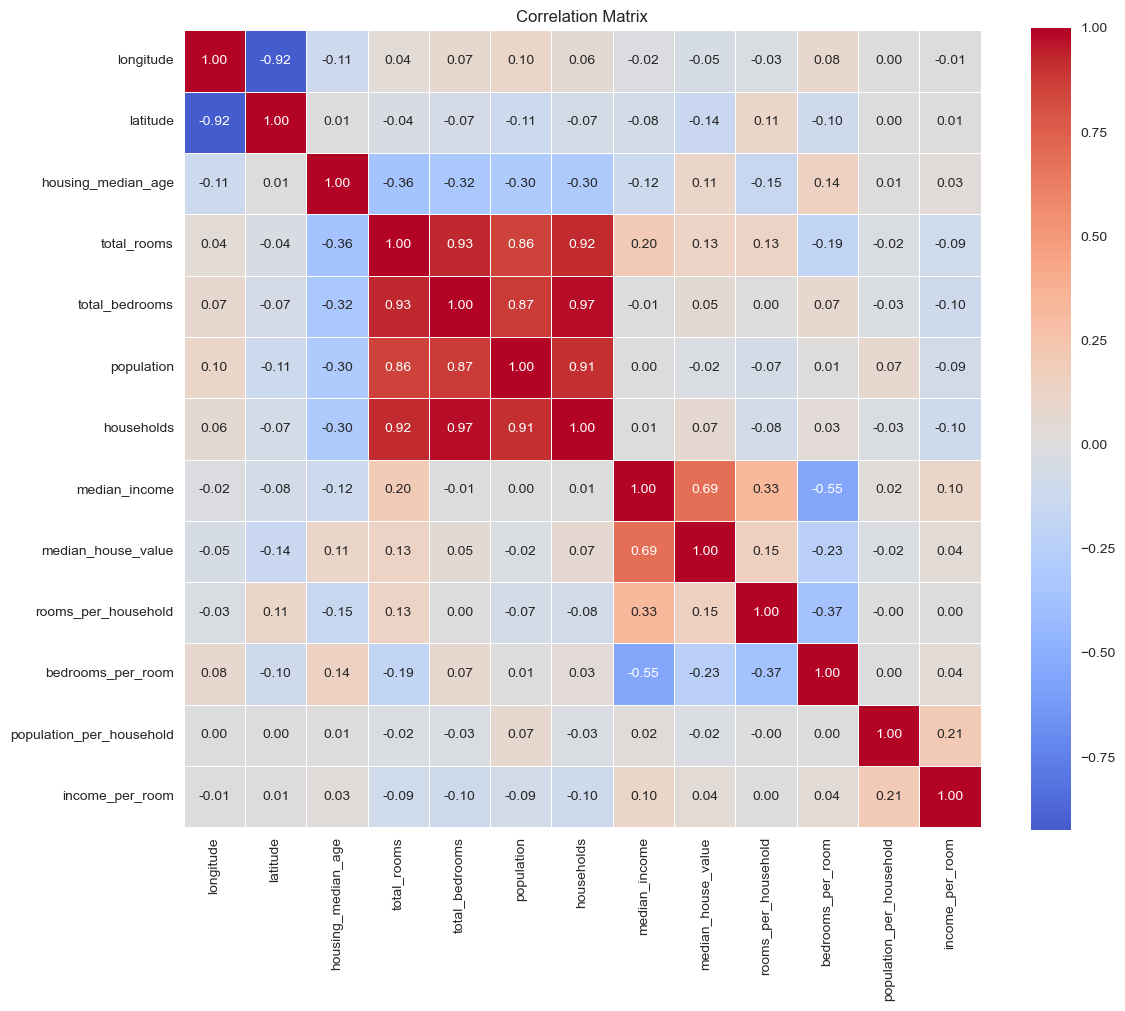

In [16]:
# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = housing_clean.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [17]:
# Correlaciones con el target
target_correlations = correlation_matrix['median_house_value'].sort_values(ascending=False)
print("\nCorrelaciones con precio de vivienda:")
for feature, corr in target_correlations.items():
    if feature != 'median_house_value' and abs(corr) > 0.1:
        print(f"   {feature:25}: {corr:+.3f}")


Correlaciones con precio de vivienda:
   median_income            : +0.688
   rooms_per_household      : +0.152
   total_rooms              : +0.134
   housing_median_age       : +0.106
   latitude                 : -0.144
   bedrooms_per_room        : -0.233


La narrativa principal es clara: **el precio de una vivienda está impulsado primordialmente por la riqueza de su vecindario.** Características físicas como el tamaño y la distribución de las habitaciones actúan como modificadores secundarios del valor, mientras que la ubicación geográfica dentro del estado establece un contexto regional de precios.    
El hallazgo más crucial de la matriz de correlación es que **el ingreso mediano del hogar (median_income) es, con mucha diferencia, el predictor más fuerte del precio de la vivienda, con una correlación positiva de +0.688.** Esto significa que, como era de esperar, **el poder adquisitivo de los residentes de una zona es el motor principal que impulsa el mercado inmobiliario.** En términos simples, **los vecindarios con mayores ingresos pueden sostener y demandan viviendas de mayor valor.**

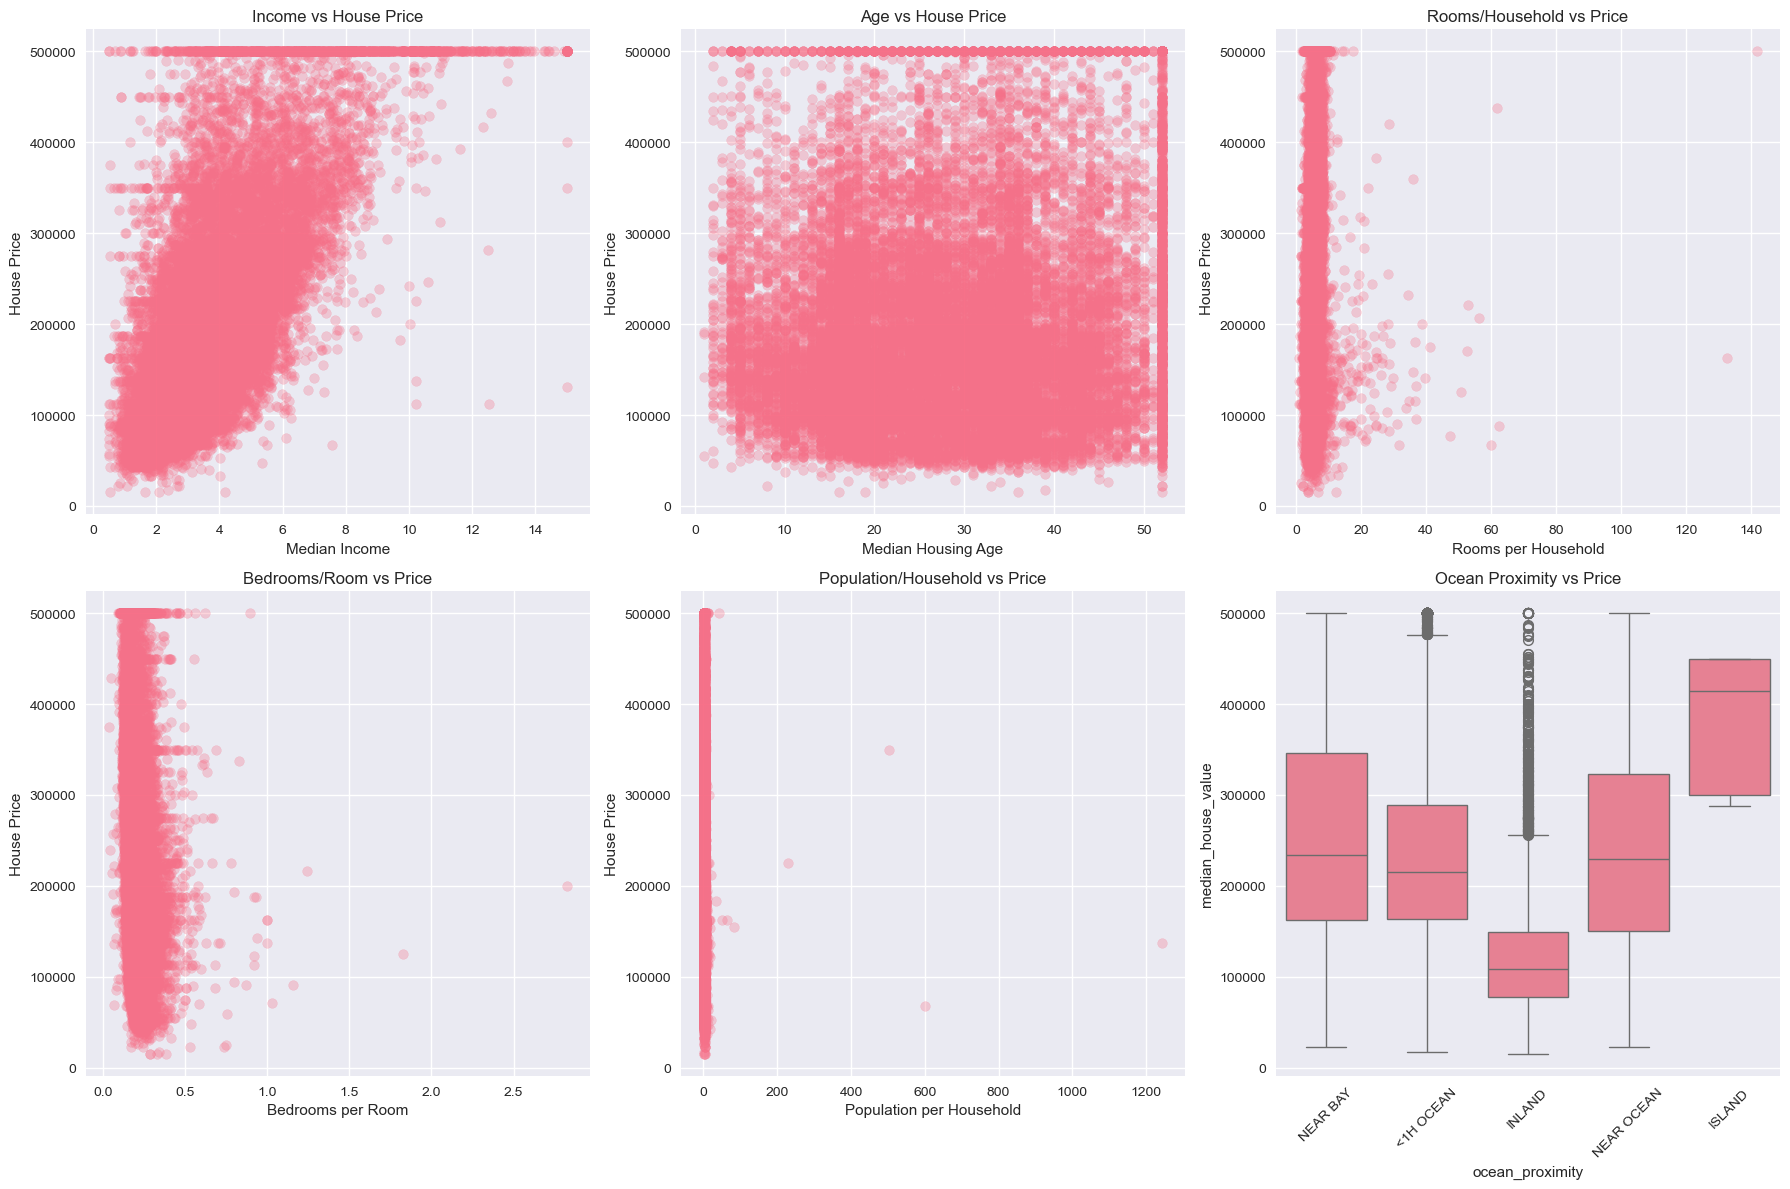

In [18]:
# Visualization of important relationships
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Median Income vs House Value
axes[0,0].scatter(housing_clean['median_income'], housing_clean['median_house_value'], alpha=0.3)
axes[0,0].set_xlabel('Median Income')
axes[0,0].set_ylabel('House Price')
axes[0,0].set_title('Income vs House Price')

# Housing Age vs House Value
axes[0,1].scatter(housing_clean['housing_median_age'], housing_clean['median_house_value'], alpha=0.3)
axes[0,1].set_xlabel('Median Housing Age')
axes[0,1].set_ylabel('House Price')
axes[0,1].set_title('Age vs House Price')

# Rooms per Household vs House Value
axes[0,2].scatter(housing_clean['rooms_per_household'], housing_clean['median_house_value'], alpha=0.3)
axes[0,2].set_xlabel('Rooms per Household')
axes[0,2].set_ylabel('House Price')
axes[0,2].set_title('Rooms/Household vs Price')

# Bedrooms per Room vs House Value
axes[1,0].scatter(housing_clean['bedrooms_per_room'], housing_clean['median_house_value'], alpha=0.3)
axes[1,0].set_xlabel('Bedrooms per Room')
axes[1,0].set_ylabel('House Price')
axes[1,0].set_title('Bedrooms/Room vs Price')

# Population per Household vs House Value
axes[1,1].scatter(housing_clean['population_per_household'], housing_clean['median_house_value'], alpha=0.3)
axes[1,1].set_xlabel('Population per Household')
axes[1,1].set_ylabel('House Price')
axes[1,1].set_title('Population/Household vs Price')

# Ocean Proximity vs House Value
sns.boxplot(data=housing_clean, x='ocean_proximity', y='median_house_value', ax=axes[1,2])
axes[1,2].set_title('Ocean Proximity vs Price')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

El gráfico más revelador es **Income vs House Price**, que muestra una relación claramente positiva: a mayor ingreso medio, mayor valor de la vivienda, aunque los precios se saturan en el límite superior de 500,000 USD, indicando un posible tope en los datos. En segundo lugar, **Ocean Proximity vs Price** evidencia que las viviendas **cerca del océano o en islas son significativamente más caras** que las del interior, lo que confirma el efecto del atractivo geográfico. En **Bedrooms/Room vs Price**, se observa que un menor número de dormitorios por habitación total se asocia con precios más altos, lo que sugiere viviendas más amplias y de mejor calidad. Por otro lado, **Rooms/Household vs Price** y **Population/Household vs Price** muestran una relación débil o casi nula con el precio, indicando que el tamaño del hogar o la cantidad de habitaciones no son factores decisivos. Finalmente, **Age vs House Price** revela una relación poco clara: tanto viviendas nuevas como antiguas pueden tener precios altos, lo que sugiere que la **antigüedad no determina por sí sola el valor de una propiedad**. En conjunto, los ingresos y la ubicación destacan como los factores más influyentes en el mercado inmobiliario.

# 6. Preparación del Modelo

In [21]:
# Define features and target variable
X = housing_clean.drop(['median_house_value'], axis=1)
y = housing_clean['median_house_value']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (16512, 13)
Test set size: (4128, 13)


In [22]:
# Preprocessing for numeric and categorical variables
numeric_features = X.select_dtypes(include=['float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print("Numeric features:", list(numeric_features))
print("Categorical features:", list(categorical_features))

Numeric features: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household', 'income_per_room']
Categorical features: ['ocean_proximity']


In [23]:
# Create transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 5. Modeling and Evaluation

In [26]:
# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR()
}

# Train and evaluate models
results = {}

for name, model in models.items():
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Train model
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'pipeline': pipeline
    }
    
    print(f"\n{name}")
    print(f"MAE: ${mae:,.2f}")
    print(f"RMSE: ${rmse:,.2f}")
    print(f"R²: {r2:.4f}")


Linear Regression
MAE: $50,926.71
RMSE: $72,830.77
R²: 0.5952

Ridge
MAE: $50,935.63
RMSE: $72,840.06
R²: 0.5951

Lasso
MAE: $50,928.06
RMSE: $72,831.52
R²: 0.5952

Random Forest
MAE: $32,464.52
RMSE: $50,554.28
R²: 0.8050

Gradient Boosting
MAE: $36,967.21
RMSE: $54,111.30
R²: 0.7766

SVR
MAE: $87,061.46
RMSE: $116,934.45
R²: -0.0435


In [28]:
# Model comparison
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[model]['MAE'] for model in results],
    'RMSE': [results[model]['RMSE'] for model in results],
    'R2': [results[model]['R2'] for model in results]
}).sort_values('RMSE')

print("Model Comparison")
print(comparison_df)

Model Comparison
               Model           MAE           RMSE        R2
3      Random Forest  32464.517459   50554.282849  0.804967
4  Gradient Boosting  36967.210366   54111.304402  0.776556
0  Linear Regression  50926.712556   72830.772415  0.595216
2              Lasso  50928.061351   72831.518507  0.595208
1              Ridge  50935.630172   72840.061317  0.595113
5                SVR  87061.457080  116934.448563 -0.043465


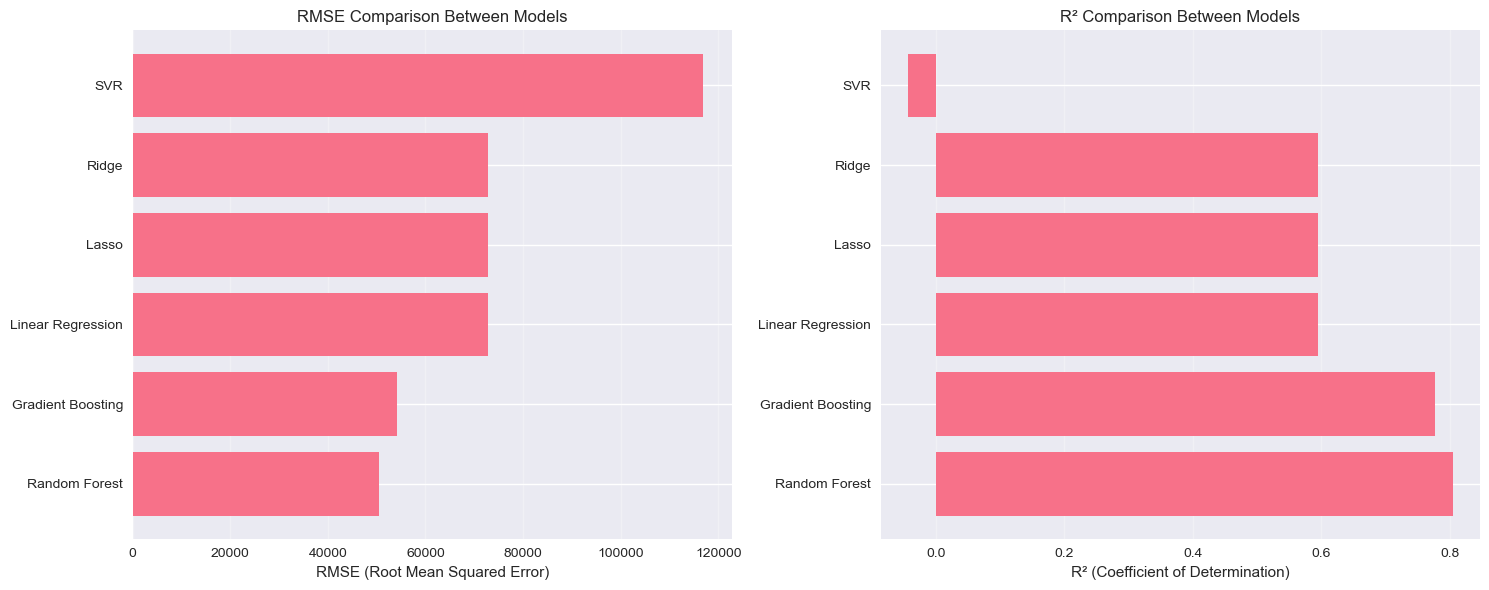

In [29]:
# Model comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# RMSE plot
axes[0].barh(comparison_df['Model'], comparison_df['RMSE'])
axes[0].set_xlabel('RMSE (Root Mean Squared Error)')
axes[0].set_title('RMSE Comparison Between Models')
axes[0].grid(axis='x', alpha=0.3)

# R² plot
axes[1].barh(comparison_df['Model'], comparison_df['R2'])
axes[1].set_xlabel('R² (Coefficient of Determination)')
axes[1].set_title('R² Comparison Between Models')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

1. **Random Forest** es el mejor modelo: tiene el **menor RMSE** (menor error promedio) y el **mayor R²**, lo que indica que **explica la mayor proporción de la variabilidad de los precios de vivienda** y realiza las predicciones más precisas.
2. **Gradient Boosting** ocupa el segundo lugar, con un rendimiento muy similar, mostrando un equilibrio excelente entre precisión y generalización.
3. **Ridge**, **Lasso** y **Linear Regression** presentan resultados intermedios: su R² ronda valores medios, lo que significa que capturan parte de la relación entre las variables, pero **no logran modelar las complejidades no lineales del conjunto de datos**.
4. Finalmente, **SVR (Support Vector Regression)** es el modelo con **peor desempeño**, mostrando el RMSE más alto y el R² más bajo, lo que indica **baja capacidad predictiva** en este caso.

# . Best Model Optimization

In [31]:
# Optimize the best model (Random Forest)
best_model_name = comparison_df.iloc[0]['Model']
print(f"Best model: {best_model_name}")

if best_model_name == 'Random Forest':
    param_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [10, 20, None],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    }
    
    rf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(random_state=42))
    ])
    
    grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, 
                              scoring='neg_mean_squared_error', 
                              n_jobs=-1, verbose=1)
    
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score: {-grid_search.best_score_:.4f}")
    
    best_model = grid_search.best_estimator_

Best model: Random Forest
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best score: 2517532966.1985


# 7. Feature Importance Analysis

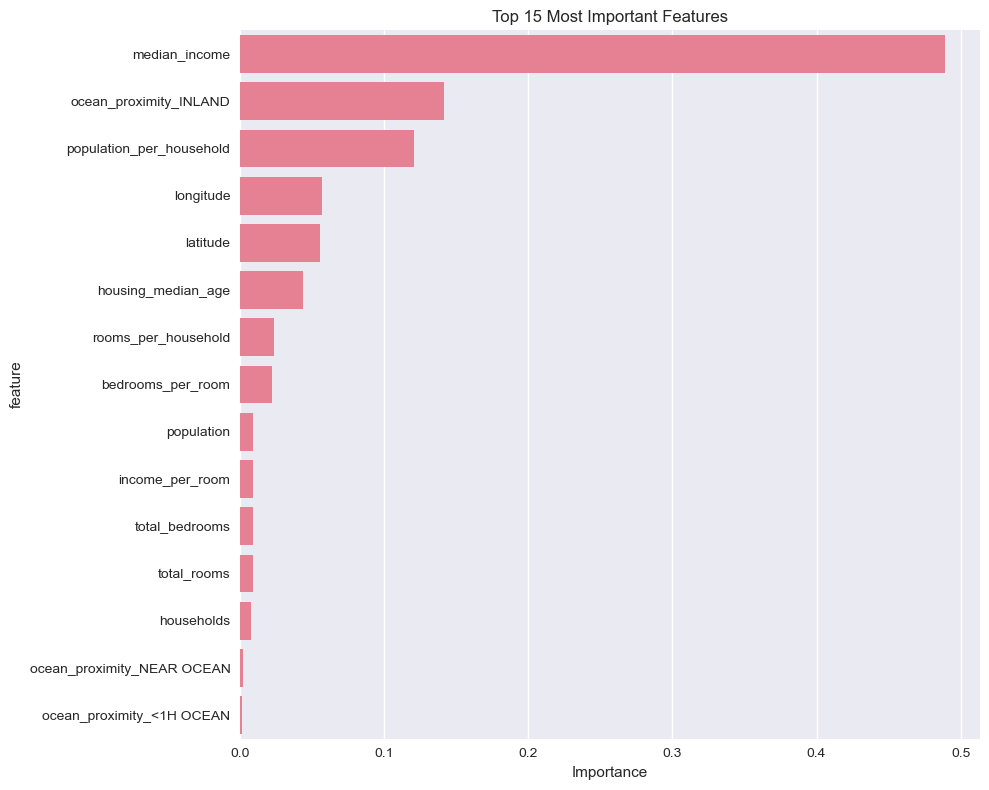

In [33]:
# Feature importance analysis for Random Forest
if best_model_name == 'Random Forest':
    feature_names = (list(numeric_features) + 
                    list(best_model.named_steps['preprocessor']
                        .named_transformers_['cat']
                        .named_steps['onehot']
                        .get_feature_names_out(categorical_features)))
    
    importances = best_model.named_steps['model'].feature_importances_
    8. Final Predictions and Residual Analysis

        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance_df.head(15), y='feature', x='importance')
    plt.title('Top 15 Most Important Features')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

El gráfico muestra las **15 variables más importantes** en la predicción del valor medio de las viviendas según el modelo (probablemente un **Random Forest o Gradient Boosting**). La **variable más influyente, con mucha diferencia, es el ingreso medio (median_income)**, lo que confirma que los **niveles de ingreso en una zona son el principal determinante del precio de la vivienda**.

En segundo lugar, destaca **ocean_proximity_INLAND**, lo que indica que **la ubicación geográfica, especialmente estar tierra adentro o cerca del océano, influye notablemente en el valor**. La **densidad poblacional por hogar (population_per_household)** también tiene un impacto importante, reflejando cómo el tamaño o la saturación de las viviendas afecta los precios.

Variables como **longitud, latitud y antigüedad de las viviendas (housing_median_age)** aportan información geográfica y temporal relevante, aunque en menor medida. Finalmente, características como **número de cuartos, dormitorios, o proximidad exacta al océano (<1H OCEAN, NEAR OCEAN)** tienen una influencia marginal.

# 8. Final Predictions and Residual Analysis

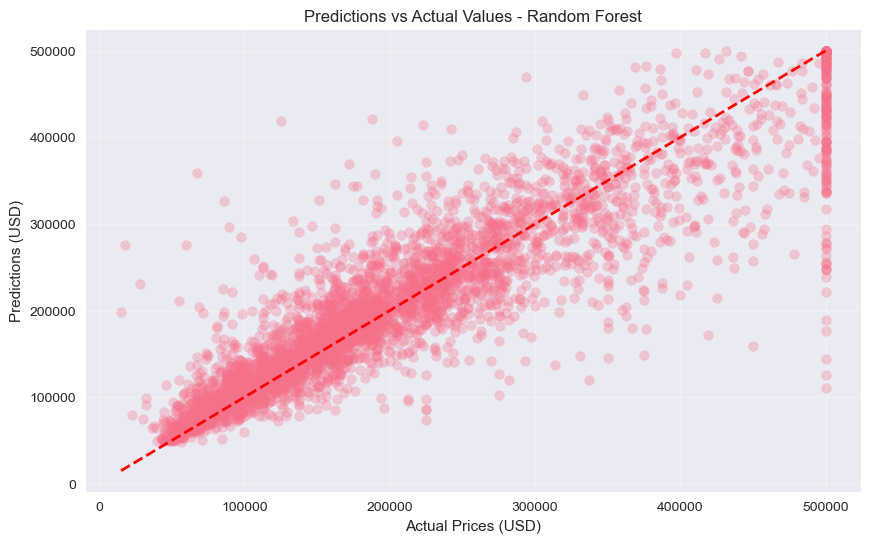

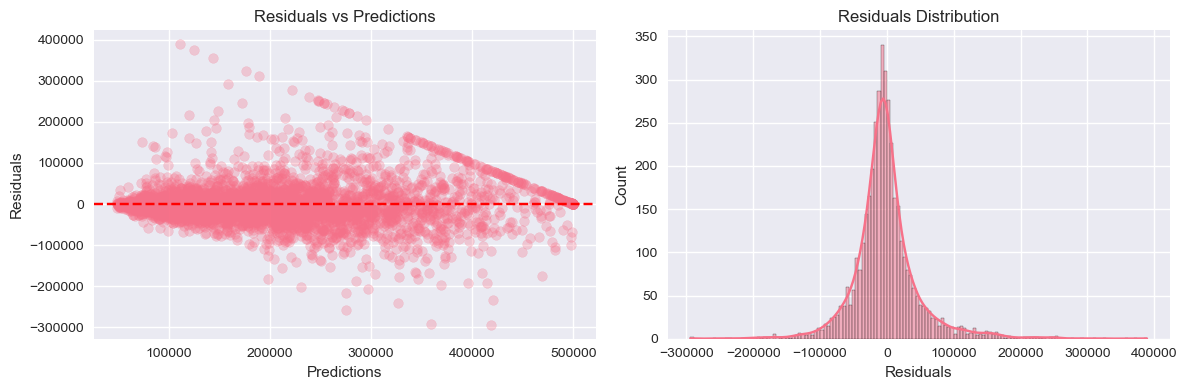

In [34]:
# Use best model for final predictions
best_pipeline = results[best_model_name]['pipeline']
y_pred_final = best_pipeline.predict(X_test)

# Predictions vs actual values plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_final, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Prices (USD)')
plt.ylabel('Predictions (USD)')
plt.title(f'Predictions vs Actual Values - {best_model_name}')
plt.grid(True, alpha=0.3)
plt.show()

# Residual analysis
residuals = y_test - y_pred_final

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_final, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residuals vs Predictions')

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Residuals Distribution')

plt.tight_layout()
plt.show()

**Predicciones vs Valores reales (arriba):**
El modelo **Random Forest** muestra una buena relación entre precios reales y predichos: los puntos siguen la línea diagonal, aunque hay cierta dispersión, especialmente en los valores altos, donde tiende a **subestimar** las viviendas más caras.

**Residuos vs Predicciones (abajo izquierda):**
Los residuos (errores) se concentran alrededor de cero, pero se observa un **patrón en forma de abanico**, indicando que el modelo tiene más error al predecir precios altos.

**Distribución de los residuos (abajo derecha):**
La distribución de los residuos es **centrada en cero** y aproximadamente **simétrica**, lo que sugiere que no hay un sesgo sistemático importante, aunque existen algunos **outliers** en los extremos.